## 项目背景
项目来源于 kaggle 在 2013 年组织的一场比赛，它使用25000张（约543M）猫狗图片作为训练集，12500张(约271M)图片作为测试集，数据都是分辨率400x400左右的小图片，目标是识别测试集中的图片是猫还是狗。赛题网址：https://www.kaggle.com/c/dogs-vs-cats。

目前 Leaderboard 上展示了 1314 支队伍的成绩，排名第一的 score 是 0.03302，Top2% 的成绩是 0.04357。本项目的最低要求是 kaggle Public Leaderboard 前 10%，即 0.06149。

## 问题陈述
深度学习中最突出的问题之一是图像分类。图像分类的目的是根据潜在的类别对特定的图像进行分类。图像分类的一个经典示例是在一组图像中识别猫和狗。

本文将介绍如何在图像分类问题中实施迁移学习解决方案。主要是使用"监督学习”实现一个图像分类器，来识别一张图片是猫还是狗。

对于图像识别，在数据量足量大的情况下，一般使用深度学习中的卷积神经网络（Convolutional Neural Networks, CNN），而本文将从迁移学习的角度，看看如何应用现有的深度学习模型（ResNet50、InceptionV3 和 Xception），从图片中提取特征，供分类器使用。使用此方法，即无需大量学习和训练模型的时间成本，又能解决图片识别相关的大多数问题。

本项目需要对测试样本进行分类，然后基于 CNN 的模型进行训练，并将结果上传至 kaggle 进行评分。

## 数据集
此数据集可以从 kaggle 上下载。[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)
下载 kaggle 猫狗数据集解压后分为 3 个文件 train.zip、 test.zip 和 sample_submission.csv。

train 训练集包含了 25000 张猫狗的图片，猫狗各一半，每张图片包含图片本身和图片名。命名规则根据 “type.num.jpg” 方式命名。

test 测试集包含了 12500 张猫狗的图片，没有标定是猫还是狗，每张图片命名规则根据 “num.jpg”，需要注意的是测试集编号从 1 开始，而训练集的编号从 0 开始。

sample_submission.csv 需要将最终测试集的测试结果写入.csv 文件中，上传至 kaggle 进行打分。

## 导入库

In [185]:
import os
import shutil
import h5py
import numpy as np
import math
import pandas as pd
from sklearn.utils import shuffle
from PIL import Image
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
from keras import Input, Model
from keras.applications import ResNet50, InceptionV3, inception_v3, Xception, xception
from keras.layers import Lambda, GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.preprocessing.image import *
from keras.models import *

In [186]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## 数据清洗
在做计算机视觉的任务时，第一步很重要的事情是看看要做的是什么样的数据集，是非常干净的？还是存在各种遮挡的？猫和狗是大是小？图片清晰度一般怎么样？会不会数据集中有标注错误的数据，比例是多少？

In [139]:
def dataRemove(path):
    if(os.path.exists(path)):
        os.remove(path)
    else:
        print("the target del file is not exist")

def dataStatistics(path):
    
    imagelist = os.listdir(path)
    
    total_width = 0
    total_height = 0
    avg_width = 0
    avg_height = 0
    count = 0
    min_width = 10000
    min_height = 10000
    max_width = 0
    max_height = 0
    min_product = 100000001
    min_product_width = 0
    min_product_height = 0
    
    for x in imagelist:
        image_name = path + "/" + x
        image = Image.open(image_name)
        width = image.size[0]
        height = image.size[1]
        total_width += width
        total_height += height
        if min_width > width:
            min_width = width
        if min_height > height:
            min_height = height
        if max_width < width:
            max_width = width
        if max_height < height:
            max_height = height
        if min_product > width * height:
            min_product = width * height
            min_product_width = width
            min_product_height = height
            if min_product < (100 * 100):
                print("{} is below 100* 100 resolution，image size is {}*{}".format(image_name, min_product_width, min_product_height))
                dataRemove(image_name)
        count += 1
    print(count)
    avg_width = total_width / count
    avg_height = total_height / count
    print("avg_width={}\navg_height={}\nThe total number of image is {}".format(avg_width, avg_height, count))
    print("The min width is {}\nThe max width is {}".format(min_width, max_width))
    print("The min height is {}\nThe max height is {}".format(min_height, max_height))
    print("The min image size is {}*{}".format(min_product_width, min_product_height))

In [140]:
dataStatistics('./test')

./test/1757.jpg is below 100* 100 resolution，image size is 95*71
./test/12324.jpg is below 100* 100 resolution，image size is 55*104
./test/11604.jpg is below 100* 100 resolution，image size is 60*54
./test/5669.jpg is below 100* 100 resolution，image size is 37*50
12500
avg_width=404.22448
avg_height=359.93072
The total number of image is 12500
The min width is 37
The max width is 500
The min height is 44
The max height is 500
The min image size is 37*50


In [141]:
dataStatistics('./train')

./train/dog.8987.jpg is below 100* 100 resolution，image size is 71*95
./train/cat.2095.jpg is below 100* 100 resolution，image size is 75*79
./train/dog.11248.jpg is below 100* 100 resolution，image size is 99*37
./train/dog.9246.jpg is below 100* 100 resolution，image size is 65*46
./train/dog.10747.jpg is below 100* 100 resolution，image size is 50*38
25000
avg_width=404.09904
avg_height=360.47808
The total number of image is 25000
The min width is 42
The max width is 1050
The min height is 32
The max height is 768
The min image size is 50*38


## 数据预处理
由于我们的数据集的文件名是以 type.num.jpg 这样的方式命名，如 cat.0.jpg，但是使用 Keras 的 ImageDataGenerator 需要将不同种类的图片分在不同的文件夹中，因此我们需要对数据集进行预处理。这里我们采取的思路是创建符号链接(symbol link)，优点是不用复制一遍图片，占用不必要的空间。

In [187]:
train_list = os.listdir('train')
# 找出所有的猫
train_cat = filter(lambda x:x[:3] == 'cat', train_list)
# 找出所有的狗
train_dog = filter(lambda x:x[:3] == 'dog', train_list)

In [188]:
# 定义创建目标路径方法
def mkdir(path):
    folder = os.path.exists(path)
    if folder:
        shutil.rmtree(path)
    os.mkdir(path)

In [189]:
# 定义 训练集的 symlink 文件夹名字
train_symlink_path = 'train-symlink'

# 创建 训练集的 symlink 文件夹
mkdir(train_symlink_path)

# 分类猫图片到 train-symlink/cat 下
os.mkdir(train_symlink_path + '/cat')
for filename in train_cat:
    os.symlink('../../train/' + filename, train_symlink_path + '/cat/' + filename)

# 分类狗图片到  train-symlink/dog 下
os.mkdir(train_symlink_path + '/dog')
for filename in train_dog:
    os.symlink('../../train/' + filename, train_symlink_path + '/dog/' + filename)

In [190]:
# 定义 测试集的 symlink 文件夹名字 
test_symlink_path = 'test-symlink'

# 创建 测试集的 symlink 文件夹
mkdir(test_symlink_path)

# 分类测试集图片到  test-symlink/test 下
os.symlink('../test/', test_symlink_path + '/test')

## 导出特征向量

为了提高模型的表现，本项目决定使用预训练网络，最终选择了ResNet50, Xception, Inception V3 这三个模型，由于在笔记本上跑的，三个模型导出的时间耗了一天时间，时常有中途下载失败的情况。 这三个模型都是在 ImageNet 上面预训练过的，由此我们实际的预测训练会带来极高的初始精度。我们可以将多个不同的网络输出的特征向量先保存下来，后续即使是在普通笔记本上也能轻松训练。

In [191]:
"""
定义通用函数
入参：模型、输入图片的大小、预处理函数
"""
def write_gap(MODEL, image_size, lambda_func=None):
    input_tensor = Input(shape=(image_size[0], image_size[1], 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
         
    base_model = MODEL( include_top=False, weights='imagenet', input_tensor=x)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

    # 用于测试的增强配置
    test_datagen = ImageDataGenerator(rescale=1./255)

    # 定义了两个 generator
    # 读取在train中找到的图片，并无限期地生成大量的增强图像数据
    train_generator = train_datagen.flow_from_directory(
                                              "train-symlink", 
                                              target_size = image_size, 
                                              shuffle=False, 
                                              batch_size=32,
                                              class_mode='binary')
    
    test_generator = test_datagen.flow_from_directory(
                                             "train-symlink", 
                                             target_size = image_size, 
                                             shuffle=False, 
                                             batch_size=32, 
                                             class_mode='binary')

    # 导出特征向量
    train = model.predict_generator(train_generator, 
                                    math.ceil(train_generator.samples*1.0/train_generator.batch_size), 
                                    verbose=1)
    test = model.predict_generator(test_generator, 
                                   math.ceil(test_generator.samples*1.0/test_generator.batch_size), 
                                   verbose=1)
    
    # 此项目选择了：ResNet50, Xception, InceptionV3 这三个模型
    if MODEL == ResNet50:
        model_name = "gap_ResNet50.h5"
    elif MODEL == Xception:
        model_name = "gap_Xception.h5"
    elif MODEL == InceptionV3:
        model_name = "gap_InceptionV3.h5"
        
    with h5py.File(model_name) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

In [33]:
write_gap(ResNet50, (224, 224))

/anaconda3/envs/Python37/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
391/391 [==============================] - 1692s 4s/step


In [34]:
write_gap(Xception, (299, 299), xception.preprocess_input)

83689472/83683744 [==============================] - 204s 2us/step
Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
391/391 [==============================] - 5768s 15s/step


In [35]:
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
391/391 [==============================] - 1671s 4s/step


## 载入特征向量

现在我们获得了3个特征向量文件：

- gap_ResNet50.h5
- gap_Xception.h5
- gap_InceptionV3.h5

把三个模型合并在一起，每个图片就有2048*3个权重值

In [192]:
np.random.seed(2019)

X_train = []
X_test = []

for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

我们基于这些权重值建立一个全连接

训练深度神经网络的时候，总是会遇到两大缺点：

（1）容易过拟合

（2）费时

Dropout可以比较有效的缓解过拟合的发生，在一定程度上达到正则化的效果。

In [193]:
inputs = Input(X_train.shape[1:])
x = Dropout(0.25)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

model.compile(optimizer='adadelta', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

模型可视化

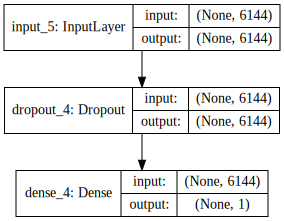

In [199]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## 模型训练

In [195]:
fit = model.fit(X_train, y_train, batch_size=128, epochs=8, validation_split=0.2, verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 7s 364us/step - loss: 0.0826 - acc: 0.9740 - val_loss: 0.0293 - val_acc: 0.9932
Epoch 2/8
20000/20000 [==============================] - 6s 301us/step - loss: 0.0191 - acc: 0.9937 - val_loss: 0.0199 - val_acc: 0.9936
Epoch 3/8
20000/20000 [==============================] - 6s 289us/step - loss: 0.0144 - acc: 0.9950 - val_loss: 0.0212 - val_acc: 0.9942
Epoch 4/8
20000/20000 [==============================] - 6s 296us/step - loss: 0.0129 - acc: 0.9954 - val_loss: 0.0186 - val_acc: 0.9946
Epoch 5/8
20000/20000 [==============================] - 6s 301us/step - loss: 0.0104 - acc: 0.9967 - val_loss: 0.0187 - val_acc: 0.9952
Epoch 6/8
20000/20000 [==============================] - 6s 306us/step - loss: 0.0097 - acc: 0.9970 - val_loss: 0.0205 - val_acc: 0.9942
Epoch 7/8
20000/20000 [==============================] - 6s 293us/step - loss: 0.0083 - acc: 0.9978 - val_loss: 0.0180 - val_acc:

8 次 epochs，训练完不到1分钟，第一次达到了97%，后面7次均达到了99%

保存模型

In [196]:
model.save('model.h5')

## 预测测试集

In [197]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.002, max=0.998)

12500/12500 [==============================] - 1s 61us/step


测试集结果保存至sample_submission.csv，以供提交至Kaggle上查看成绩

In [198]:
df = pd.read_csv("sample_submission.csv")

path = 'test-symlink/'

# 原图
data_generator = image.ImageDataGenerator()
generator_data = data_generator.flow_from_directory(
                                                                            path, 
                                                                            batch_size=32, 
                                                                            shuffle=False, 
                                                                            class_mode='binary', 
                                                                            target_size=(224, 224))

for i, x in enumerate(generator_data.filenames):
    index = int(x[x.rfind('/')+1:x.rfind('.')]) - 1
    df.set_value(index, 'label', y_pred[i])

df.to_csv('pred_result.csv', index=None)

df.head(10)

Found 12500 images belonging to 1 classes.


/anaconda3/envs/Dogs-vs-cats/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


,id,label
0,1,0.998
1,2,0.998
2,3,0.998
3,4,0.998
4,5,0.002
5,6,0.002
6,7,0.002
7,8,0.002
8,9,0.002
9,10,0.002


## 参考文献

- https://blog.csdn.net/niuwei22007/article/details/49207187
- https://keras.io/visualization/
- https://zhuanlan.zhihu.com/p/25978105?utm_source=weibo 
- https://keras-cn-docs.readthedocs.io/zh_CN/latest/blog/image_classification_using_very_little_data
- https://keras-cn.readthedocs.io/en/latest/layers/pooling_layer
- https://blog.csdn.net/shizhengxin123/article/details/72473245